# Download Data 

Once the data is successfuly downloaded from [https://gea.esac.esa.int/archive/](https://gea.esac.esa.int/archive/), and correctly decompressed following the instroctions provided in [Neeed to add link to README from personal github](add-link), we can now import the data on Python and store it as a data frame using the package [pandas](https://pandas.pydata.org/).

Optional, add the following to the sql code to remove impurity in data:
```sql
WHERE gs.parallax < 5 * gs.parallax_error  -- Remove potential stars
AND gs.ruwe < 1.4  -- Ensure good astrometric quality
AND gs.phot_g_mean_mag < 21  -- Bright enough for good measurements
```

In [1]:
from src.data import data_download # Run Python file to download data

INFO: Query finished. [astroquery.utils.tap.core]


In [5]:
import pandas as pd
# Load into Pandas
df = pd.read_csv("csv_files/qso_full_data.csv")
print(df.head())  # Check the data

        source_id         ra       dec      pmra     pmdec  parallax  \
0   3470333738112  45.075505  0.152316 -1.072371 -3.191011  0.366321   
1   5944234902272  44.884761  0.164806 -0.121274  0.725026 -0.395659   
2   6459630980096  44.910498  0.189649  0.217806 -0.316007 -0.626561   
3   9517648372480  45.254655  0.228999 -0.552941 -1.895446 -0.917219   
4  10892037246720  45.188575  0.282424 -0.098037 -0.120580  0.001630   

   parallax_error      ruwe  phot_g_mean_mag  nu_eff_used_in_astrometry  \
0        0.901633  0.889714        20.571114                   1.526179   
1        1.340139  1.087911        20.704517                   1.647388   
2        0.548536  1.020956        20.173105                        NaN   
3        1.507964  1.031971        20.634562                        NaN   
4        0.246332  0.974657        18.787239                   1.565118   

   pmra_error  pmdec_error  pmra_pmdec_corr  astrometric_params_solved  
0    1.552507     1.226259         0.207769

### Column Content

Before we procede, we need to understand what each column contains, to do so let us print the heading of each column.

In [3]:
# Check column names
print(df.columns)

Index(['source_id', 'ra', 'dec', 'pmra', 'pmdec', 'parallax', 'parallax_error',
       'ruwe', 'phot_g_mean_mag', 'nu_eff_used_in_astrometry', 'pmra_error',
       'pmdec_error', 'pmra_pmdec_corr', 'astrometric_params_solved'],
      dtype='object')


The output above, displays:

1. <b>source_id</b>, Unique Gaia identifier for the object
2. <b>ra</b>, Right Ascension (celestial longitude) in degrees
3. <b>dec</b>, Declination (celestial latitude) in degrees
4. <b>pmra</b>, Proper motion in Right Ascension (mas/yr)
5. <b>pmdec</b>, Proper motion in Declination (mas/yr)
6. <b>parallax</b>, Parallax measurament (this is expected to be near zero for distant QSOs)
7. <b>ruwe</b>, Renormalised Unit Weight Error (this indicates the quality of the data point)
8. <b>phot_g_mean_mag</b>, Mean magnitude in Gaia's G-band 
9. <b>nu_eff_used_in_astrometry</b>, Efficient wavenumber denoted as $\nu_{eff}$, this is used to charecterise the color of a celestial object by describing how its light is distributed across different wavelenghts.
10. <b>parallax_error</b>, measure the uncentainty on parralax (standard deviation).
11. <b>pmra_error</b>, Uncertainty in pmra.
12. <b>pmdec_error</b>, Uncertainty in pmdec_error.

We want to make suere the data matches the description provided in the papaer, i.e. we expect there to be 1614173 sources which are identified as QSO-like objects. 

# Filtering Data
In this section we aim to remove potential outliers from the five parameter solution dataset.

## Plan 

1. Initial Least Square Fit $\rightarrow$ Fit the VSH model using all data.
2. Compute $X^2$ Values $\rightarrow$ For each QSO
3. Compute the Median $\rightarrow$ Compute the median of all $X$ values.
4. Reject Outliers $\rightarrow$ If $X>\kappa \times \text{median}(X)$, mark the source as outlier.
5. Refit $\rightarrow$ Exclude outliers and re-run the fit.
6. Iterate $\rightarrow$ Repeate steps (e.g. 2-5) until convergence (i.e. outlier stops changing).

## Procedure In EDR3
1. Perform Least Square $\rightarrow$ estimate VSH coefficients
2. $\kappa$-Clipping $\rightarrow$ remove outliers
3. Perform Bootstrapping $\rightarrow$ quantify the uncertainty of results

## Our approach
Keep step 1 and 2 from EDR3, nut instrad:
1. Perform Least Square $+$ $\kappa$-Clipping $\rightarrow$ filter the data
2. Perform HMC (Bayesian inference) sampling on filtered dataset $\rightarrow$ achieving posterior samples, with VSH coefficient estimate and uncertainities.

In [3]:
import jax.numpy as jnp
from jax import jit, vmap
from functools import partial, lru_cache
from src.models.vsh_model import*
import pandas as pd
from iminuit import Minuit # to perform least square
from src.models.configuration import*
from src.data.data_utils import*
import gc

In [4]:
# Load data
df = load_qso_dataframe()
angles, obs, error = config_data(df)

In [5]:
def robust_least_squares_fit(angles, obs, error, theta_init, lmax = 3, kappa=3.0, max_iter=10):

    
    alpha, delta = angles
    mu_a_obs, mu_d_obs = obs
    s_mu_a, s_mu_d, rho = error

    keep = jnp.ones_like(alpha, dtype=bool)
    theta = theta_init

    prev_outliers = None

    for iteration in range(max_iter):
        print('Iteration:', iteration+1)
        alpha_k, delta_k = alpha[keep], delta[keep]
        obs_k = (mu_a_obs[keep], mu_d_obs[keep])
        err_k = (s_mu_a[keep], s_mu_d[keep], rho[keep])
        angles_k = (alpha_k, delta_k)

        def least_square_wrapper(*theta_flat):
            theta_arr = jnp.array(theta_flat)
            return least_square(angles_k, obs_k, err_k, theta_arr, lmax=lmax, grid=False)

        m = Minuit(least_square_wrapper, *theta)
        m.errordef = Minuit.LEAST_SQUARES

        m.migrad()

        theta = jnp.array([m.values[name] for name in m.parameters])

        C0 = 1000/np.sqrt(8*np.pi/3)
        C1 = 1000/np.sqrt(4*np.pi/3)

        print(f'Current g components [μas/yr]: gx = {-theta[4]*C1}, gy = {theta[5]*C1}, gz = {theta[1]*C0}')

        del m
        gc.collect()
        jax.clear_caches()

        # Compute X^2 over full dataset (not just kept subset)
        X = np.sqrt(compute_X2(alpha, delta, mu_a_obs, mu_d_obs, s_mu_a, s_mu_d, rho, theta, lmax))
        median_X = jnp.median(X)
        keep = X < kappa*median_X

        print(f"Rejected: {(~keep).sum()} sources")

        if prev_outliers is not None and jnp.array_equal(keep, prev_outliers):
            print(f"Converged after {iteration+1} iterations.")
            break
        prev_outliers = keep

    return theta, keep


In [4]:
lmax = 3
total_params = count_vsh_coeffs(lmax)
theta_init = jnp.zeros(total_params)

theta, keep = robust_least_squares_fit(angles, obs, error, theta_init)

print(f'Length of keep array: {len(keep)}')

Iteration: 1
Current g components [μas/yr]: gx = -0.293548583984375, gy = -4.0919294357299805, gz = -2.8633511066436768
Rejected: 3787 sources
Iteration: 2
Current g components [μas/yr]: gx = -0.1732703298330307, gy = -4.25071382522583, gz = -2.678118944168091
Rejected: 3788 sources
Iteration: 3
Current g components [μas/yr]: gx = -0.16842861473560333, gy = -4.266857147216797, gz = -2.665255308151245
Rejected: 3786 sources
Iteration: 4
Current g components [μas/yr]: gx = -0.16842861473560333, gy = -4.266857147216797, gz = -2.665255308151245
Rejected: 3787 sources
Iteration: 5
Current g components [μas/yr]: gx = -0.13661928474903107, gy = -4.272395610809326, gz = -2.6614580154418945
Rejected: 3785 sources
Iteration: 6
Current g components [μas/yr]: gx = -0.13488395512104034, gy = -4.272395610809326, gz = -2.6614580154418945
Rejected: 3785 sources
Converged after 6 iterations.
Length of keep array: 1215942


In [ ]:
df_clean = df.loc[np.array(keep)]
# Saving filtered dataset
df_clean.to_csv('csv_files/filtered_qso_data.csv', index=False)

# Model

## Least Square (for $l=1$ Toy Model)

We successfully downloaded, loaded and filtered the data for 5 parameters solution, we defined the toroidal and spheroidal functions ($T_{lm}$ and $S_{lm}$), respectively modelling the right ascension (ra) and declination (dec). For $\alpha \in [0, 2\pi]$ and $\delta \in [-\pi/2,\pi/2]$ we visualised the VSH vector fields. We now want to perform a MLE on the dataset.

To do so, we will follow closely the procedure presented in the main paper (Gaia Early Data Release 3 Acceleration of the Solar System from Gaia astrometry). This assumes that the noise follows a Gaussian model, i.e. the astrometric measurement errors (in proper motion, parallax, etc.) are:
- Unbiased (zero mean),
- Independent between different sources (quasars),
- With known standard deviation and correlations, as provided in Gaia EDR3.

This allows the least-square estimation framework and the statistical significance tests, in particular using the $\chi^2$ distributions for assessing power in VSH.

Recall Eq. 5 amd 7:
$$
V(\alpha, \delta) = \sum_{l=1}^{l_{\text{max}}} \left( t_{l0} T_{l0} + s_{l0} S_{l0}
+ 2 \sum_{m=1}^{l} \left( t_{lm}^{\mathbb{R}} T_{lm}^{\mathbb{R}} - t_{lm}^{\mathbb{I}} T_{lm}^{\mathbb{I}} + s_{lm}^{\mathbb{R}} S_{lm}^{\mathbb{R}} - s_{lm}^{\mathbb{I}} S_{lm}^{\mathbb{I}} \right) \right)\tag{5}
$$

$$
X^2 = \begin{bmatrix}
\Delta\mu_{\alpha^*} & \Delta\mu_{\delta} \\
\end{bmatrix}
\begin{bmatrix}
\sigma_{\mu_{\alpha^*}}^2 & \rho_{\mu}\sigma_{\mu_{\alpha^*}}\sigma_{\mu_{\delta}} \\
\rho_{\mu}\sigma_{\mu_{\alpha^*}}\sigma_{\mu_{\delta}} & \sigma_{\mu_{\delta}}^2
\end{bmatrix}
\begin{bmatrix}
\Delta\mu_{\alpha^*} \\ \Delta\mu_{\delta} 
\end{bmatrix}\tag{7}
$$

where:
- $\Delta\mu_{\alpha^*} = \mu_{\alpha^* \text{obs}} - V_{\alpha^* \text{model}}$ is the difference between observed and predicted proper motion right ascension (ra).
- $\Delta\mu_{\delta} = \mu_{\delta \text{obs}} - V_{\delta \text{model}}$ is the difference between observed and predicted proper motion declination (dec).

Since each proper motion componet is assumed to follow a Gaussian distribution, MLE simplifies to a weighted least squares. Hence our objective is to minimise Eq. 7:

$$
\sum_k \begin{bmatrix}
\Delta\mu_{\alpha^*} & \Delta\mu_{\delta} \\
\end{bmatrix}
\begin{bmatrix}
\sigma_{\mu_{\alpha^*}}^2 & \rho_{\mu}\sigma_{\mu_{\alpha^*}}\sigma_{\mu_{\delta}} \\
\rho_{\mu}\sigma_{\mu_{\alpha^*}}\sigma_{\mu_{\delta}} & \sigma_{\mu_{\delta}}^2
\end{bmatrix}
\begin{bmatrix}
\Delta\mu_{\alpha^*} \\ \Delta\mu_{\delta} 
\end{bmatrix}
$$

# HMC Sampling on Filtered Data

In [2]:
import jax
import jax.numpy as jnp
import numpyro
from numpyro.infer import NUTS, MCMC, Predictive
from numpyro import handlers
from numpyro.diagnostics import summary
import numpyro.distributions as dist
from src.models.vsh_model import*
from src.models.configuration import*
from src.data.data_utils import*
from src.plot.plots import*

Conversion to Galactic latitude, and longitude (b, l)

In [3]:
df = load_filtered_qso_df() # load filtered data
angles, obs, error = config_data(df)

In [4]:
def chi2_jit(angles, obs, error, theta, lmax):
    return least_square(angles, obs, error, theta, lmax=lmax, grid=False)
chi2_jit = jit(chi2_jit, static_argnames=['lmax'])

# Define Model with Uniform prior
def model_uni_prior(angles, obs, error, limit = 1., lmax = 3):
    total_params = count_vsh_coeffs(lmax)
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Uniform(-limit, limit).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)

# Definie Model with Gaussian Prior
def model_norm_prior(angles, obs, error, std = 1., lmax = 3):

    total_params = count_vsh_coeffs(lmax)
    # Prior on all VSH coefficients (both toroidal and spheroidal)
    theta = numpyro.sample("theta", dist.Normal(0., std).expand([total_params]))
    # Least-squares residuals: we assume Gaussian-distributed residuals
    chi2_val = chi2_jit(angles, obs, error, theta, lmax=lmax)

    # The log-likelihood is proportional to -0.5*chi^2
    numpyro.factor("likelihood", -0.5*chi2_val)


n_s = 5000 # number of samples
n_warmup = 2000 #  number of warmups 
n_chains = 4 # numbe of chains

In [5]:
rng_key = jax.random.key(0)

kernel_uni = NUTS(model_uni_prior, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%
mcmc_uni = MCMC(kernel_uni, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method='sequential', progress_bar=True)
mcmc_uni.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
posterior_sample_uniform = mcmc_uni.get_samples()

diagnostic_uni = summary(mcmc_uni.get_samples(group_by_chain=True))

r_hat_uni = diagnostic_uni['theta']['r_hat']
n_eff_uni = diagnostic_uni['theta']['n_eff']

print('Coefficients of interest, s_10, s_11r and s_11i')
print(f'Their respsecive r_hat values are: {r_hat_uni[1]}, {r_hat_uni[4]} and {r_hat_uni[5]}')
print(f'Their respective effective sample size are : {n_eff_uni[1]}, {n_eff_uni[4]} and {n_eff_uni[5]}')

mcmc_uni.print_summary()

sample: 100%|██████████| 7000/7000 [03:41<00:00, 31.60it/s, 15 steps of size 2.66e-01. acc. prob=0.86] 


Coefficients of interest, s_10, s_11r and s_11i
Their respsecive r_hat values are: 0.9999523162841797, 1.000130295753479 and 0.999878466129303
Their respective effective sample size are : 15540.0106051887, 15998.982272005554 and 22069.678340382645

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.00      0.00      0.00     -0.00      0.00  11243.95      1.00
  theta[1]     -0.01      0.00     -0.01     -0.01     -0.01  15540.01      1.00
  theta[2]     -0.01      0.00     -0.01     -0.01     -0.00  18639.31      1.00
  theta[3]      0.00      0.00      0.00      0.00      0.00  23369.47      1.00
  theta[4]      0.00      0.00      0.00     -0.00      0.00  15998.98      1.00
  theta[5]     -0.01      0.00     -0.01     -0.01     -0.01  22069.68      1.00
  theta[6]      0.00      0.00      0.00      0.00      0.01  13500.19      1.00
  theta[7]     -0.00      0.00     -0.00     -0.01     -0.00  16261.34      1.00
  theta[8]      0.00  

### Trace Plots

- For all coefficients of the octapole
- For all the spheroidal coefficients of the dipole

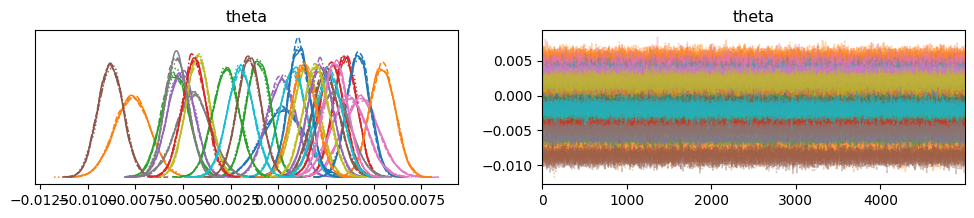

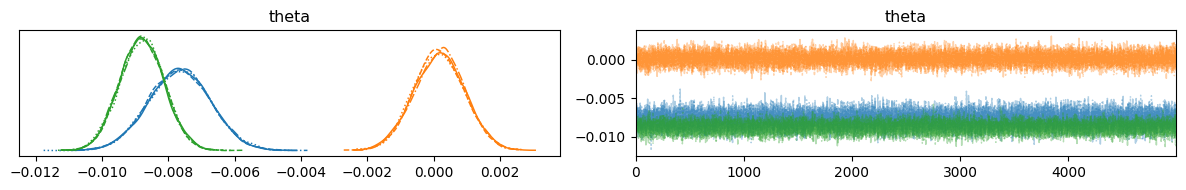

In [5]:
traceplot_check(mcmc=mcmc_uni)

In [6]:
cov_m = cov_matrix_hmc(posterior_sample_uniform['theta'], indices=[4,5,1])
result_uni = jnp.mean(posterior_sample_uniform['theta'], axis = 0)
params = [result_uni[1], result_uni[4], result_uni[5]]

summary_uni, v_vec, v_Sigma, corr_eq = vsh_vector_summary(params, cov_m)
summary_uni_gal, v_vec_gal, v_Sigma_gal, corr_gal = vsh_vector_summary_galactic(v_vec, v_Sigma)

lb_summary_ = lb_summary(v_vec_gal, v_Sigma_gal)
ra_dec_summary_ = ra_dec_summary(v_vec, v_Sigma)


In [7]:
print_summary(summary_uni, title='Result, Equatorial Coordinates')
print_summary(ra_dec_summary_)
print('')
print_summary(summary_uni_gal, title='Results, Galactic Coordinates')
print_summary(lb_summary_)

Result, Equatorial Coordinates
------------------------------
  |g| (μas/yr)        : 5.0479
  g (μas/yr)          : [-0.07715945 -4.2972355  -2.6475039 ]
  |sigma_g| (μas/yr)  : 0.3204
  sigma_g (μas/yr)    : [0.37047928 0.32449165 0.31869984]
  Corr_gx_gy          : -0.0027
  Corr_gx_gz          : -0.0893
  Corr_gy_gz          : -0.0155
  RA (deg)            : 268.9713
  Sigma_RA (deg)      : 4.9389
  Dec (deg)           : -31.6329
  Sigma_Dec (deg)     : 3.6660
  Corr_RA_dec         : -0.0352

Results, Galactic Coordinates
-----------------------------
  |g|_gal (μas/yr)    : 5.0479
  g_gal (μas/yr)      : [ 5.03855407 -0.10422582 -0.28908929]
  |sigma_g_gal| (μas/yr): 0.3204
  sigma_g_gal (μas/yr): [0.32026671 0.32317725 0.37027695]
  Corr_g_galx_g_galy  : 0.0413
  Corr_g_galx_g_galz  : -0.0134
  Corr_g_galy_g_galz  : -0.0839
  l (deg)             : 358.8150
  Sigma_l (deg)       : 3.6773
  b (deg)             : -3.2831
  Sigma_b (deg)       : 4.1986
  Corr_l_b            : -0.0014

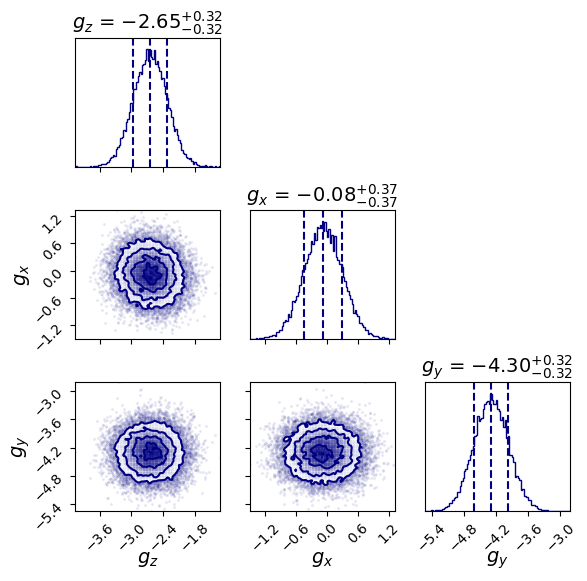

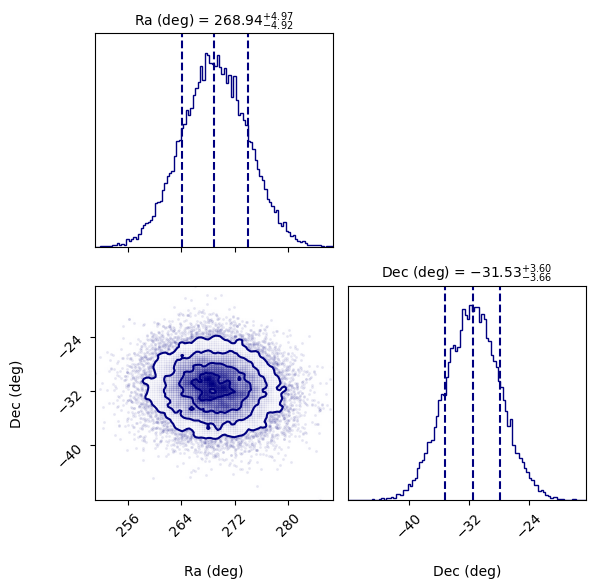

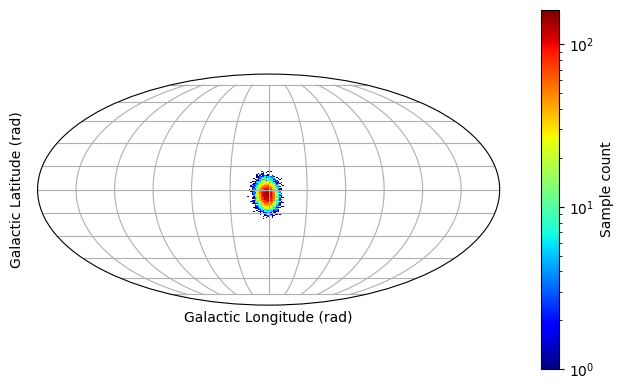

In [8]:
corner_plot_eq_comp(posterior_sample_uniform, save = 'Corner_galactic_uni')
corner_plot_ra_dec(posterior_sample_uniform, save = 'RA_Ded_dist_uni')
mollweide_proj_galactic(posterior_sample_uniform, save = 'lb_dist_uni')


In [8]:
rng_key = jax.random.key(0)

kernel_norm = NUTS(model_norm_prior, target_accept_prob=0.75) # this is to make sure acceptance does not exceed 90%
mcmc_norm = MCMC(kernel_norm, num_warmup=n_warmup, num_samples=n_s, num_chains=n_chains, chain_method='sequential', progress_bar=True)
mcmc_norm.run(rng_key, angles = angles, obs = obs, error = error, lmax=3)
posterior_sample_norm = mcmc_norm.get_samples()

diagnostic_norm = summary(mcmc_norm.get_samples(group_by_chain=True))

r_hat_norm = diagnostic_norm['theta']['r_hat']
n_eff_norm = diagnostic_norm['theta']['n_eff']

print('Coefficients of interest, s_10, s_11r and s_11i')
print(f'Their respsecive r_hat values are: {r_hat_norm[1]}, {r_hat_norm[4]} and {r_hat_norm[5]}')
print(f'Their respective effective sample size are : {n_eff_norm[1]}, {n_eff_norm[4]} and {n_eff_norm[5]}')

mcmc_norm.print_summary()

sample: 100%|██████████| 7000/7000 [03:53<00:00, 29.95it/s, 15 steps of size 1.52e-01. acc. prob=0.85]


Coefficients of interest, s_10, s_11r and s_11i
Their respsecive r_hat values are: 0.9999483227729797, 0.9999914169311523 and 0.9998534321784973
Their respective effective sample size are : 15120.19489606007, 17201.469066311918 and 22601.555031318658

                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.00      0.00      0.00     -0.00      0.00   8979.41      1.00
  theta[1]     -0.01      0.00     -0.01     -0.01     -0.01  15120.19      1.00
  theta[2]     -0.01      0.00     -0.01     -0.01     -0.00  18559.87      1.00
  theta[3]      0.00      0.00      0.00      0.00      0.00  24681.20      1.00
  theta[4]      0.00      0.00      0.00     -0.00      0.00  17201.47      1.00
  theta[5]     -0.01      0.00     -0.01     -0.01     -0.01  22601.56      1.00
  theta[6]      0.00      0.00      0.00      0.00      0.01  12790.92      1.00
  theta[7]     -0.00      0.00     -0.00     -0.01     -0.00  15546.30      1.00
  theta[8]      0.0

### Trace Plots

- For all coefficients of the octapole
- For all the spheroidal coefficients of the dipole

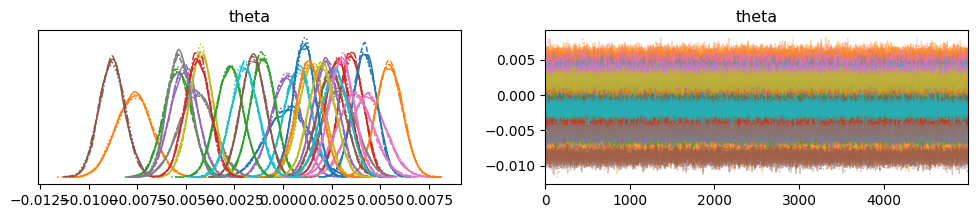

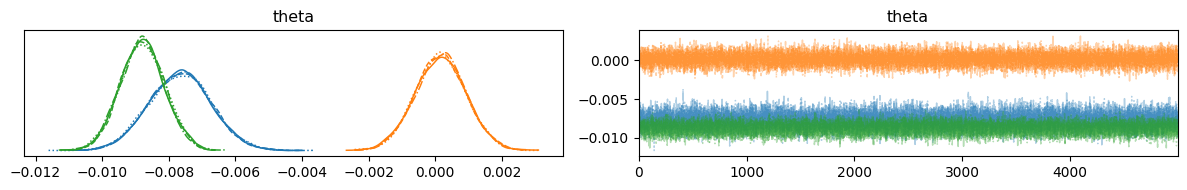

In [10]:
traceplot_check(mcmc=mcmc_norm)

In [9]:
cov_m = cov_matrix_hmc(posterior_sample_norm['theta'], indices=[1,4,5])
result_uni = jnp.mean(posterior_sample_norm['theta'], axis = 0)
params = [result_uni[1], result_uni[4], result_uni[5]]

summary_norm, v_vec, v_Sigma,_ = vsh_vector_summary(params, cov_m)
summary_norm_gal, v_vec_gal, v_Sigma_gal, _ = vsh_vector_summary_galactic(v_vec, v_Sigma)

lb_summary_ = lb_summary(v_vec_gal, v_Sigma_gal)
ra_dec_summary_ = ra_dec_summary(v_vec, v_Sigma)

In [10]:
print_summary(summary_uni, title='Result, Equatorial Coordinates')
print_summary(ra_dec_summary_)
print('')
print_summary(summary_uni_gal, title='Results, Galactic Coordinates')
print_summary(lb_summary_)

Result, Equatorial Coordinates
------------------------------
  |g| (μas/yr)        : 5.0479
  g (μas/yr)          : [-0.07715945 -4.2972355  -2.6475039 ]
  |sigma_g| (μas/yr)  : 0.3204
  sigma_g (μas/yr)    : [0.37047928 0.32449165 0.31869984]
  Corr_gx_gy          : -0.0027
  Corr_gx_gz          : -0.0893
  Corr_gy_gz          : -0.0155
  RA (deg)            : 268.9645
  Sigma_RA (deg)      : 6.0305
  Dec (deg)           : -31.6415
  Sigma_Dec (deg)     : 3.1182
  Corr_RA_dec         : 0.0453

Results, Galactic Coordinates
-----------------------------
  |g|_gal (μas/yr)    : 5.0479
  g_gal (μas/yr)      : [ 5.03855407 -0.10422582 -0.28908929]
  |sigma_g_gal| (μas/yr): 0.3204
  sigma_g_gal (μas/yr): [0.32026671 0.32317725 0.37027695]
  Corr_g_galx_g_galy  : 0.0413
  Corr_g_galx_g_galz  : -0.0134
  Corr_g_galy_g_galz  : -0.0839
  l (deg)             : 358.8046
  Sigma_l (deg)       : 3.8839
  b (deg)             : -3.2823
  Sigma_b (deg)       : 4.5890
  Corr_l_b            : -0.0077


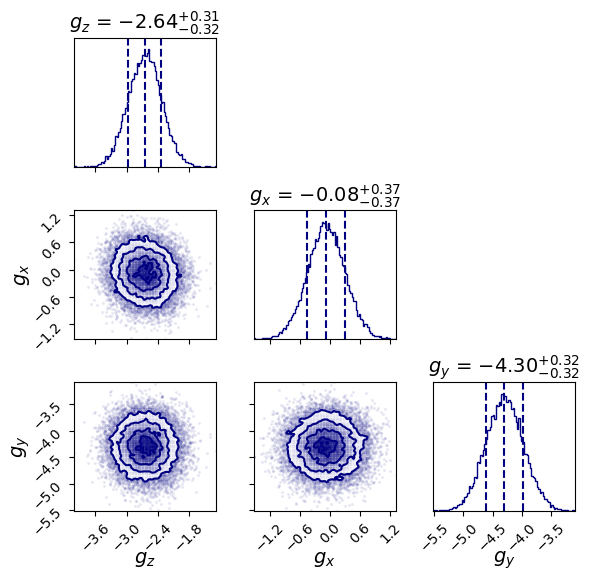

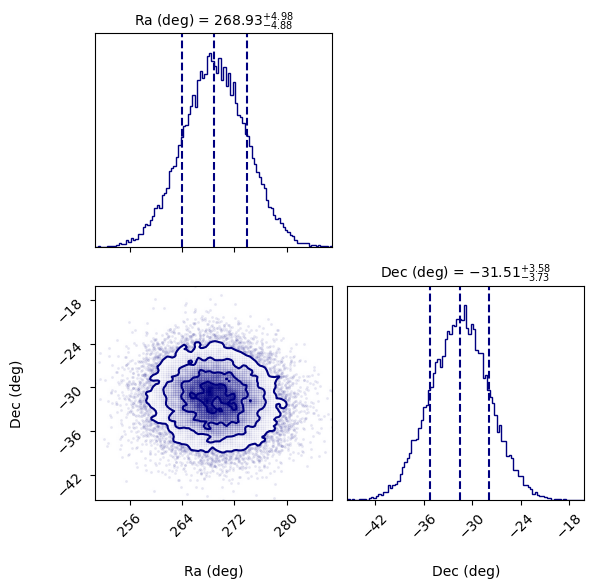

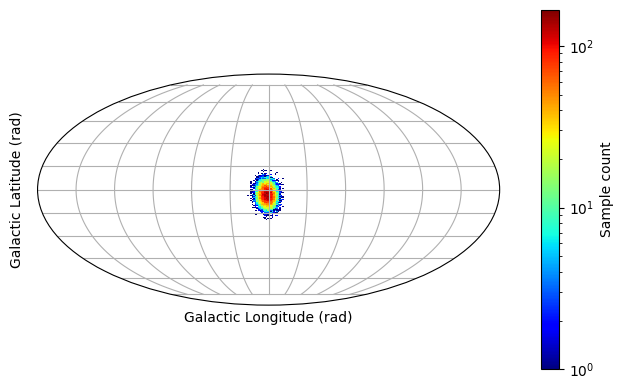

In [13]:
corner_plot_eq_comp(posterior_sample_norm, save = 'Corner_galactic_norm')
corner_plot_ra_dec(posterior_sample_norm, save = 'RA_Ded_dist_norm')
mollweide_proj_galactic(posterior_sample_norm, save = 'lb_dist_norm')